In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.tsa.stattools as sts

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Processing

In [ ]:
path = '/content/drive/MyDrive/google ADA/GOOGL_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(path)
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [ ]:
# Converting Date column to datetime
df['Date'] = pd.to_datetime(df.Date, yearfirst=True)
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [ ]:
df.set_index('Date', inplace=True) # Setting the index to date

df = df.asfreq('b') # Setting the frequency to business days

df.drop('Name', axis=1, inplace=True) # Dropping useless columns

# Checking clusters of NaN and filling NaN

In [ ]:
# Create a boolean mask for NaN values
nan_mask = df['Open'].isna()

# Check for consecutive NaN values using the shift() function
consecutive_nan_mask = nan_mask & nan_mask.shift(-1)

consecutive_nan_mask.sum() # Checking how many consecutive nan there are

3

In [ ]:
df[(df.index.day < 5) * (df.index.month == 1) * (df.index.year == 2007)]

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-01,NaN,NaN,NaN,NaN,NaN
2007-01-02,NaN,NaN,NaN,NaN,NaN
2007-01-03,233.23,238.57,230.79,234.03,7722839.0
2007-01-04,234.73,242.22,234.41,241.87,7916458.0


In [ ]:
df[(df.index.day < 6) * (df.index.month == 4) * (df.index.year == 2010)]

,Open,High,Low,Close,Volume
Date,,,,,
2010-04-01,NaN,NaN,NaN,NaN,NaN
2010-04-02,NaN,NaN,NaN,NaN,NaN
2010-04-05,285.74,287.73,284.78,285.79,1902063.0


In [ ]:
df[(df.index.day > 25) * (df.index.month == 10) * (df.index.year == 2012)]

,Open,High,Low,Close,Volume
Date,,,,,
2012-10-26,338.59,341.86,335.94,337.91,1950865.0
2012-10-29,NaN,NaN,NaN,NaN,NaN
2012-10-30,NaN,NaN,NaN,NaN,NaN
2012-10-31,340.27,340.84,337.84,340.49,1537001.0


In [ ]:
df[consecutive_nan_mask]

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-01,NaN,NaN,NaN,NaN,NaN
2010-04-01,NaN,NaN,NaN,NaN,NaN
2012-10-29,NaN,NaN,NaN,NaN,NaN


In [ ]:
aux = df[consecutive_nan_mask]
df = df[~consecutive_nan_mask]

In [ ]:
df = df.fillna(method='bfill') # Backfilling

# Adding the other samples
df = df.asfreq('b')
df = df.fillna(method='ffill') # Sampling them using frontfill

In [ ]:
df.isna().sum().sum()

0

In [ ]:
input_vars = df.shape[1]

# Normalization

In [ ]:
train_size = 0.8
val_size = 0.1
train_samples = int(df.shape[0]*train_size)
val_samples = int(df.shape[0]*(train_size+val_size))

scaler = StandardScaler()
df.iloc[:train_samples] = scaler.fit_transform(df.iloc[:train_samples])
df.iloc[train_samples:] = scaler.transform(df.iloc[train_samples:])

In [ ]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,-0.904145,-0.873545,-0.899456,-0.854099,2.876012
2006-01-04,-0.821233,-0.822217,-0.815559,-0.815269,3.550220
2006-01-05,-0.813096,-0.812183,-0.808704,-0.791940,2.149591
2006-01-06,-0.770943,-0.738935,-0.762899,-0.736059,4.322127
2006-01-09,-0.733903,-0.727743,-0.732908,-0.731253,2.769132


# Lagging variables

In [ ]:
n_lagged = 50

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # n_in = number of lagged variables in the past
    # n_out = number of lagged variables in the future
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    col_names = data.columns
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(col_names[j]+'(t-%d)' % (i,)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [col_names[j]+'(t)' for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# frame as supervised learning
reframed = series_to_supervised(df, n_lagged, 1)
# drop columns we don't want to predict
reframed.head()
print(reframed.shape)

(3079, 255)


In [ ]:
# At time "t", we only have Open(t) and want to predict Close(t), so we can drop High(t), Volume(t) and Low(t)
# Also we will drop Open(t-1) because each time step needs to have exactly 4 variables. If we add more time steps we will have
# a remaining Variable (Open(t)) to spare, so we will replace Open(t-1) with Open(t) for the first lagged variable.
reframed.drop(['High(t)', 'Low(t)', 'Volume(t)', 'Open(t-'+str(n_lagged)+')'], axis=1, inplace=True)
reframed.head()

,High(t-50),Low(t-50),Close(t-50),Volume(t-50),Open(t-49),High(t-49),Low(t-49),Close(t-49),Volume(t-49),Open(t-48),...,Low(t-2),Close(t-2),Volume(t-2),Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Open(t),Close(t)
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-14,-0.873545,-0.899456,-0.854099,2.876012,-0.821233,-0.822217,-0.815559,-0.815269,3.550220,-0.813096,...,-1.237381,-1.233175,4.815238,-1.220530,-1.219563,-1.222191,-1.234880,3.035635,-1.235253,-1.180162
2006-03-15,-0.822217,-0.815559,-0.815269,3.550220,-0.813096,-0.812183,-0.808704,-0.791940,2.149591,-0.770943,...,-1.222191,-1.234880,3.035635,-1.235253,-1.195327,-1.233175,-1.180162,4.542192,-1.182406,-1.206048
2006-03-16,-0.812183,-0.808704,-0.791940,2.149591,-0.770943,-0.738935,-0.762899,-0.736059,4.322127,-0.733903,...,-1.233175,-1.180162,4.542192,-1.182406,-1.195558,-1.202327,-1.206048,2.761922,-1.190775,-1.228292
2006-03-17,-0.738935,-0.762899,-0.736059,4.322127,-0.733903,-0.727743,-0.732908,-0.731253,2.769132,-0.741652,...,-1.202327,-1.206048,2.761922,-1.190775,-1.209297,-1.212609,-1.228292,1.901114,-1.228821,-1.224339
2006-03-20,-0.727743,-0.732908,-0.731253,2.769132,-0.741652,-0.739938,-0.728624,-0.720170,1.614286,-0.715074,...,-1.212609,-1.228292,1.901114,-1.228821,-1.236235,-1.224216,-1.224339,1.443441,-1.215106,-1.191710


# Data splitting

In [ ]:
train_X, train_y = reframed.iloc[:train_samples, :-1].values, reframed.iloc[:train_samples, -1].values
val_X, val_y = reframed.iloc[train_samples:val_samples, :-1].values, reframed.iloc[train_samples:val_samples, -1].values
test_X, test_y = reframed.iloc[val_samples:, :-1].values, reframed.iloc[val_samples:, -1].values

# Reshaping data for LSTM

In [ ]:
train_X = train_X.reshape((train_X.shape[0], n_lagged, input_vars))
val_X = val_X.reshape((val_X.shape[0], n_lagged, input_vars))
test_X = test_X.reshape((test_X.shape[0], n_lagged, input_vars))

In [ ]:
train_X.shape

(2503, 50, 5)

# LSTM

Epoch 1/100
79/79 - 12s - loss: 0.0430 - val_loss: 0.0174 - 12s/epoch - 157ms/step
Epoch 2/100
79/79 - 1s - loss: 0.0092 - val_loss: 0.0136 - 903ms/epoch - 11ms/step
Epoch 3/100
79/79 - 1s - loss: 0.0078 - val_loss: 0.0123 - 1s/epoch - 13ms/step
Epoch 4/100
79/79 - 1s - loss: 0.0065 - val_loss: 0.0115 - 1s/epoch - 14ms/step
Epoch 5/100
79/79 - 1s - loss: 0.0056 - val_loss: 0.0108 - 896ms/epoch - 11ms/step
Epoch 6/100
79/79 - 1s - loss: 0.0050 - val_loss: 0.0101 - 971ms/epoch - 12ms/step
Epoch 7/100
79/79 - 1s - loss: 0.0046 - val_loss: 0.0095 - 1s/epoch - 14ms/step
Epoch 8/100
79/79 - 1s - loss: 0.0043 - val_loss: 0.0089 - 986ms/epoch - 12ms/step
Epoch 9/100
79/79 - 1s - loss: 0.0040 - val_loss: 0.0084 - 1s/epoch - 15ms/step
Epoch 10/100
79/79 - 1s - loss: 0.0037 - val_loss: 0.0082 - 1s/epoch - 14ms/step
Epoch 11/100
79/79 - 1s - loss: 0.0034 - val_loss: 0.0087 - 966ms/epoch - 12ms/step
Epoch 12/100
79/79 - 1s - loss: 0.0033 - val_loss: 0.0124 - 874ms/epoch - 11ms/step
Epoch 13/100
79/

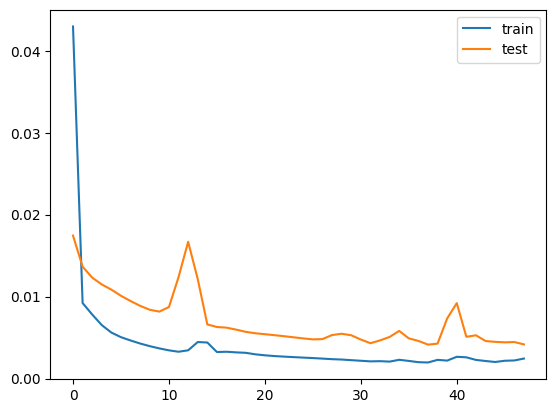

In [ ]:
hidden_layer_neurons = 500
batch_size = 32
epochs = 100
learning_rate = 0.0005

# Optimizer and callbacks
optimizer = Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Defining model
model = Sequential()
model.add(LSTM(hidden_layer_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1)) # Output layer
model.compile(loss='mse', optimizer=optimizer)

# Fit network
t0 = time.time()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(val_X, val_y), verbose=2, shuffle=False,
                   callbacks = [early_stopping])
t1 = time.time()
print("Total execution time:", t1-t0)
lstm_training_time = t1-t0

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Predicting

In [ ]:
mean = scaler.mean_[scaler.feature_names_in_ == 'Close'][0]
std = np.sqrt(scaler.var_[scaler.feature_names_in_ == 'Close'][0])

9/9 [==============================] - 0s 4ms/step


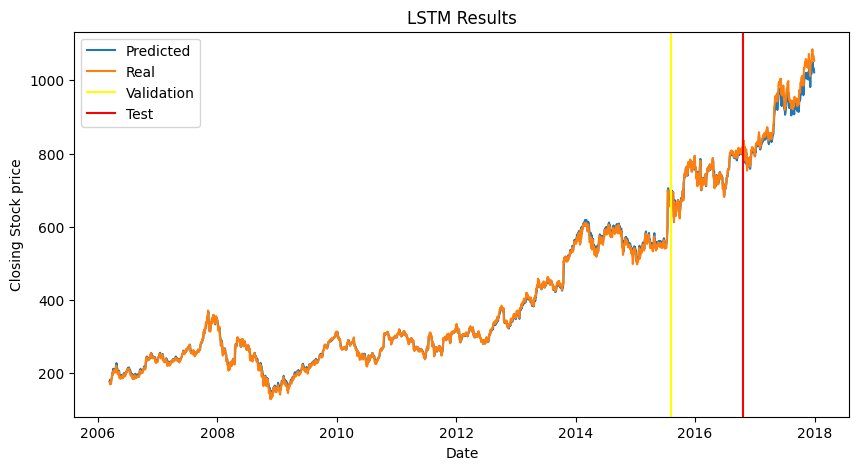

In [ ]:
plt.subplots(figsize=(10, 5))

# make a prediction
yhat_train = model.predict(train_X).flatten()
yhat_val = model.predict(val_X).flatten()
yhat_test = model.predict(test_X).flatten()

# Concatenate the results
y_pred = np.concatenate([yhat_train, yhat_val, yhat_test])* std + mean
y_real = np.concatenate([train_y, val_y, test_y]) * std + mean

# Plot
plt.plot(df.iloc[n_lagged:].index, y_pred, label='Predicted')
plt.plot(df.iloc[n_lagged:].index, y_real, label='Real')

plt.axvline(x = df.iloc[[train_samples]].index, color = 'yellow', label = 'Validation')
plt.axvline(x = df.iloc[[val_samples]].index, color = 'red', label = 'Test')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock price")
plt.title("LSTM Results")
plt.show()

In [ ]:
# Getting metrics
# MSE
train_rmse = np.sqrt( mean_squared_error( y_real[:train_samples], y_pred[:train_samples] ) )
val_rmse = np.sqrt( mean_squared_error( y_real[train_samples:val_samples], y_pred[train_samples:val_samples] ) )
test_rmse = np.sqrt( mean_squared_error( y_real[val_samples:], y_pred[val_samples:] ) )

# MAE
train_mae = mean_absolute_error( y_real[:train_samples], y_pred[:train_samples] )
val_mae = mean_absolute_error( y_real[train_samples:val_samples], y_pred[train_samples:val_samples] )
test_mae = mean_absolute_error( y_real[val_samples:], y_pred[val_samples:] )


In [ ]:
print(test_mae, test_rmse)

19.275156045775905 22.266656672605667


In [ ]:
print(val_mae, val_rmse)

6.244501882924819 8.304002839785124


In [ ]:
print(train_mae, train_rmse)

4.8236215640352675 6.559795612706466


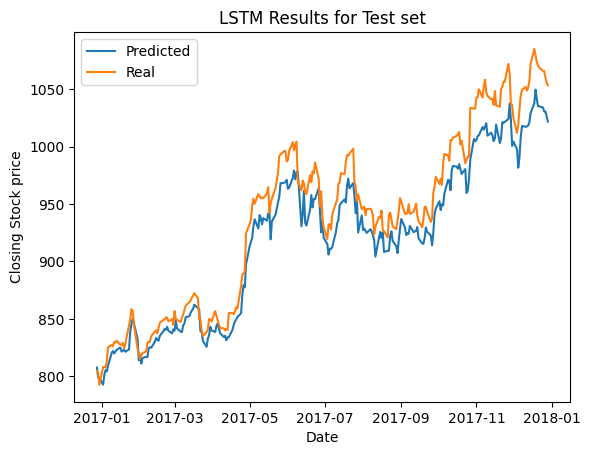

In [ ]:
# Plot
plt.plot(df.iloc[n_lagged+val_samples:].index, y_pred[val_samples:], label='Predicted')
plt.plot(df.iloc[n_lagged+val_samples:].index, y_real[val_samples:], label='Real')


plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock price")
plt.title("LSTM Results for Test set")
plt.show()

In [ ]:
aux = pd.read_csv(path)

In [ ]:
np.mean((aux.iloc[train_samples: val_samples]['Open'] - aux.iloc[train_samples: val_samples]['Close']))

0.28335463258785926

In [ ]:
mean_absolute_error(aux.iloc[val_samples:]['Open'] + 0.28, aux.iloc[val_samples:]['Close'])

5.830394088669956

In [ ]:
test_rmse_LSTM = test_rmse
test_mae_LSTM = test_mae
val_rmse_LSTM = val_rmse
val_mae_LSTM = val_mae
train_rmse_LSTM = train_rmse
train_mae_LSTM = train_mae

# Simple RNN model




Epoch 1/50
79/79 [==============================] - 5s 49ms/step - loss: 0.1731 - val_loss: 0.0424
Epoch 2/50
79/79 [==============================] - 3s 43ms/step - loss: 0.0241 - val_loss: 0.0236
Epoch 3/50
79/79 [==============================] - 2s 31ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 4/50
79/79 [==============================] - 2s 30ms/step - loss: 0.0094 - val_loss: 0.0127
Epoch 5/50
79/79 [==============================] - 2s 29ms/step - loss: 0.0059 - val_loss: 0.0100
Epoch 6/50
79/79 [==============================] - 3s 33ms/step - loss: 0.0048 - val_loss: 0.0099
Epoch 7/50
79/79 [==============================] - 4s 51ms/step - loss: 0.0039 - val_loss: 0.0095
Epoch 8/50
79/79 [==============================] - 3s 38ms/step - loss: 0.0035 - val_loss: 0.0089
Epoch 9/50
79/79 [==============================] - 2s 30ms/step - loss: 0.0034 - val_loss: 0.0080
Epoch 10/50
79/79 [==============================] - 2s 31ms/step - loss: 0.0033 - val_loss: 0.0072
Epoch 11/

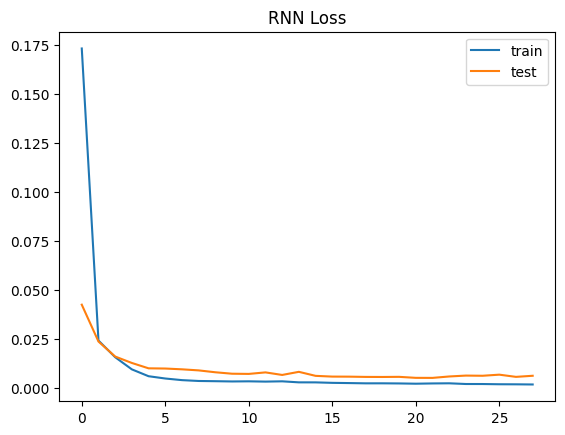

9/9 [==============================] - 0s 8ms/step


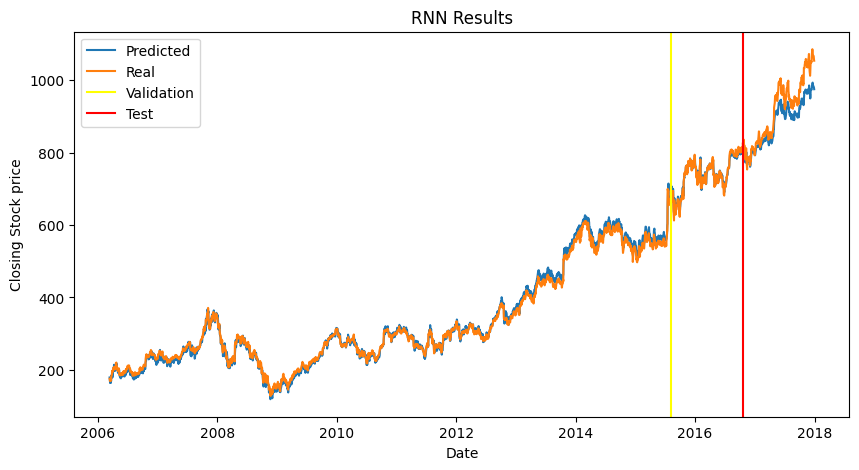

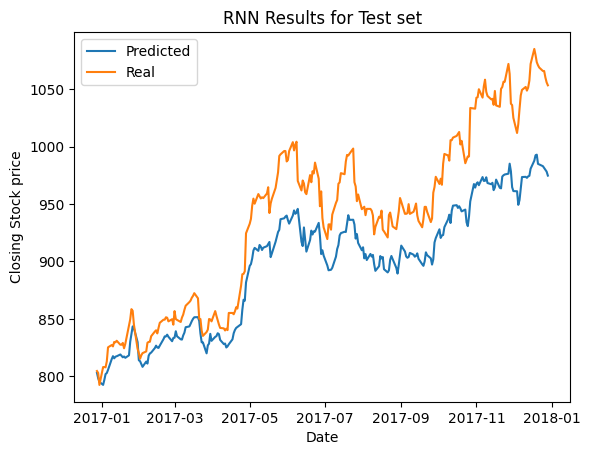

Test RMSE: 47.24543629492
Test MAE: 40.90055800521328
Validation RMSE: 9.20456783269929
Validation MAE: 7.147303213296227
Train RMSE: 10.345353219895644
Train MAE: 8.257159843734394


(None, None)

In [ ]:
# RNN model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

hidden_layer_neurons = 700
batch_size = 32
epochs = 50
learning_rate = 0.0005

model_rnn = Sequential()
model_rnn.add(SimpleRNN(hidden_layer_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model_rnn.add(Dense(1))

# Fit network
t0 = time.time()

optimizer = Adam(learning_rate=learning_rate)
model_rnn.compile(loss='mse', optimizer=optimizer)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history_rnn = model_rnn.fit(train_X, train_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(val_X, val_y), verbose=1, shuffle=False,
                   callbacks = [early_stopping])
t1 = time.time()
rnn_training_time = t1-t0
print("Total execution time:", t1-t0)

# Plot history
plt.plot(history_rnn.history['loss'], label='train')
plt.plot(history_rnn.history['val_loss'], label='test')
plt.legend()
plt.title("RNN Loss")
plt.show()

plt.subplots(figsize=(10, 5))

# make a prediction
yhat_train = model_rnn.predict(train_X).flatten()
yhat_val = model_rnn.predict(val_X).flatten()
yhat_test = model_rnn.predict(test_X).flatten()

# Concatenate the results
mean = scaler.mean_[scaler.feature_names_in_ == 'Close'][0]
std = np.sqrt(scaler.var_[scaler.feature_names_in_ == 'Close'][0])
y_pred = np.concatenate([yhat_train, yhat_val, yhat_test])* std + mean
y_real = np.concatenate([train_y, val_y, test_y]) * std + mean

# Plot
plt.plot(df.iloc[n_lagged:].index, y_pred, label='Predicted')
plt.plot(df.iloc[n_lagged:].index, y_real, label='Real')

plt.axvline(x = df.iloc[[train_samples]].index, color = 'yellow', label = 'Validation')
plt.axvline(x = df.iloc[[val_samples]].index, color = 'red', label = 'Test')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock price")
plt.title("RNN Results")
plt.show()

# Getting metrics
# MSE
train_rmse = np.sqrt( mean_squared_error( y_real[:train_samples], y_pred[:train_samples] ) )
val_rmse = np.sqrt( mean_squared_error( y_real[train_samples:val_samples], y_pred[train_samples:val_samples] ) )
test_rmse = np.sqrt( mean_squared_error( y_real[val_samples:], y_pred[val_samples:] ) )

# MAE
train_mae = mean_absolute_error( y_real[:train_samples], y_pred[:train_samples] )
val_mae = mean_absolute_error( y_real[train_samples:val_samples], y_pred[train_samples:val_samples] )
test_mae = mean_absolute_error( y_real[val_samples:], y_pred[val_samples:] )

# Plot
plt.plot(df.iloc[n_lagged+val_samples:].index, y_pred[val_samples:], label='Predicted')
plt.plot(df.iloc[n_lagged+val_samples:].index, y_real[val_samples:], label='Real')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock price")
plt.title("RNN Results for Test set")
plt.show()

print("Test RMSE:", test_rmse), print("Test MAE:", test_mae)
print("Validation RMSE:", val_rmse), print("Validation MAE:", val_mae)
print("Train RMSE:", train_rmse), print("Train MAE:", train_mae)


In [ ]:
print("Test RMSE:", test_rmse), print("Test MAE:", test_mae)

print("Validation RMSE:", val_rmse), print("Validation MAE:", val_mae)

print("Train RMSE:", train_rmse), print("Train MAE:", train_mae)

test_rmse_rnn = test_rmse
test_mae_rnn = test_mae
val_rmse_rnn = val_rmse
val_mae_rnn = val_mae
train_rmse_rnn = train_rmse
train_mae_rnn = train_mae

Test RMSE: 47.24543629492
Test MAE: 40.90055800521328
Validation RMSE: 9.20456783269929
Validation MAE: 7.147303213296227
Train RMSE: 10.345353219895644
Train MAE: 8.257159843734394


In [ ]:
ddf = df.shift(-1).iloc[:-1]
# Fixing open variable

In [ ]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,-0.904145,-0.873545,-0.899456,-0.854099,2.876012
2006-01-04,-0.821233,-0.822217,-0.815559,-0.815269,3.550220
2006-01-05,-0.813096,-0.812183,-0.808704,-0.791940,2.149591
2006-01-06,-0.770943,-0.738935,-0.762899,-0.736059,4.322127
2006-01-09,-0.733903,-0.727743,-0.732908,-0.731253,2.769132
...,...,...,...,...,...
2017-12-25,5.737924,5.693390,5.716651,5.718468,-0.946865
2017-12-26,5.737924,5.693390,5.716651,5.718468,-0.946865
2017-12-27,5.722116,5.688836,5.714625,5.674677,-0.885093


In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

def floatation(df, attributes):
    for var in attributes:
        df[var] = df[var].astype(str)            # converting to string
        df[var] = df[var].str.replace(',', '.')  # replacing the commas with dot decimal separatpr
        df[var] = df[var].astype(np.float32)     # converting the values into dot
    return df

def sequencing(dataset, start_index=0, end_index=None, history_size=50, step=1):
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
    return np.array(data)

def partition(data, pTrain=0.7, pVal = 0.5, save_path=None):
    # Data is already normalized
    sequencedData = sequencing(data, start_index=0, end_index=None, history_size=50, step=1)

    dataTrain = sequencedData[:train_samples]
    dataVal = sequencedData[train_samples:val_samples]
    dataTest = sequencedData[val_samples:]

    return dataTrain, dataVal, dataTest

def split(chunk):
    inputs = torch.tensor(chunk[:, :-1, :], device=device)
    targets = torch.tensor(chunk[:, 1:, :], device=device)
    return inputs, targets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def createLoaders(dataTrain, dataVal, dataTest, batchSize=32):
    XTrain, YTrain = split(dataTrain)
    XVal, YVal = split(dataVal)
    XTest, YTest = split(dataTest)

    YTrain = YTrain[:,:,[3]]
    YVal = YVal[:,:,[3]]
    YTest = YTest[:,:,[3]]

    print(YTrain.shape, XTrain.shape)

    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS = torch.utils.data.TensorDataset(XVal, YVal)
    testDS = torch.utils.data.TensorDataset(XTest, YTest)

    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize)
    valLoader = torch.utils.data.DataLoader(valDS, batch_size=batchSize)
    testLoader = torch.utils.data.DataLoader(testDS, batch_size=batchSize)

    return trainLoader, valLoader, testLoader

import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension

        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)

        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=50, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

# function that implement the look_ahead mask for masking future time steps.
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)


class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):

        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)

        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim,
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D

        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block

        x = self.output_projection(x)

        return x, attention_weights # (B,S,S)

# num_layers = [1,2,3,4]
# D = [32, 32*2, 32*4, 32*8]
# H = [1, 2, 4, 6]
# hidden_mlp_dim = [32*3, 32*6, 32 * 8, 32*10]

# it = 50
# best_loss = 100
# for i in range(it):
#   layer = num_layers[np.random.choice(4)]
#   my_D = D[np.random.choice(4)]
#   my_H = H[np.random.choice(4)]
#   hidden = hidden_mlp_dim[np.random.choice(4)]

#   transformer = Transformer(num_layers=layer, D=my_D, H=my_H, hidden_mlp_dim=hidden,
#                             inp_features=5, out_features=1, dropout_rate=0.1).to(device)
#   optimizer = torch.optim.RMSprop(transformer.parameters(),
#                                   lr=0.00001)


#   n_epochs = 300
#   attributes = list(df.columns)
#   df1 = floatation(df, attributes)
#   data = df1.values
#   losses, val_losses, test_losses = [], [],[]
#   trainData, valData, testData = partition(data)
#   trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData)
#   niter = len(trainDataset)

#   y_train_arr = []
#   y_pred_train = []

#   y_val_arr = []
#   y_pred_val = []

#   y_test_arr = []
#   y_pred_test = []

#   for e in range(n_epochs):

#       # one epoch on train set
#       transformer.train()
#       sum_train_loss = 0.0
#       for x,y in trainDataset:
#           S = x.shape[1]
#           mask = create_look_ahead_mask(S)
#           out, _ = transformer(x, mask)
#           loss = torch.nn.MSELoss()(out, y)
#           sum_train_loss += loss.item()
#           loss.backward()
#           optimizer.step()

#           if e == n_epochs-1:
#               y_train_arr.append(y[:, -1, 0])
#               y_pred_train.append(out[:, -1, 0])
#       losses.append(sum_train_loss / niter)

#       # Evaluate on val set
#       transformer.eval()
#       sum_val_loss = 0.0
#       for i, (x, y) in enumerate(valDataset):
#           S = x.shape[1]
#           mask = create_look_ahead_mask(S)
#           out, _ = transformer(x, mask)
#           loss = torch.nn.MSELoss()(out, y)
#           sum_val_loss += loss.item()
#           if e == n_epochs-1:
#               y_val_arr.append(y[:, -1, 0])
#               y_pred_val.append(out[:, -1, 0])

#       val_losses.append(sum_val_loss / (i + 1))
#       transformer.eval()
#       sum_test_loss = 0.0
#       for i, (x, y) in enumerate(testDataset):
#           S = x.shape[1]
#           mask = create_look_ahead_mask(S)
#           out, _ = transformer(x, mask)
#           loss = torch.nn.MSELoss()(out, y)
#           sum_test_loss += loss.item()

#           if e == n_epochs-1:
#               y_test_arr.append(y[:, -1, 0])
#               y_pred_test.append(out[:, -1, 0])
#       test_losses.append(sum_test_loss / (i + 1))

#   if val_losses[-1] < best_loss:
#     print(val_losses[-1])
#     print(layer, my_D, my_H, hidden)
#     best_loss = val_losses[-1]

torch.Size([2503, 49, 1]) torch.Size([2503, 49, 5])
Training Loss: 0.02578482690821343
Validation Loss: 0.16983165070414544
Test Loss: 1.3632173736890156
Training time: 89.2397530078888


Text(0.5, 1.0, 'Transformer Loss')

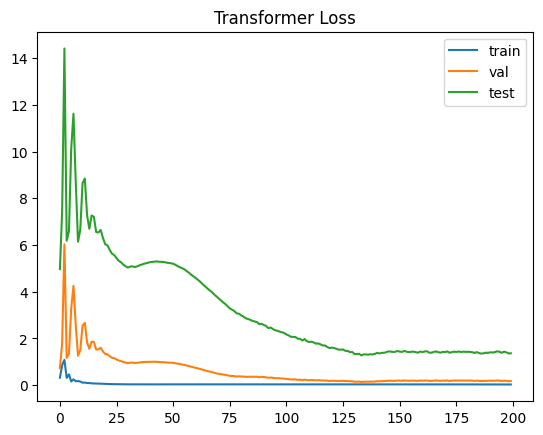

In [ ]:
layer = 1
my_D = 256
my_H = 4
hidden = 96
t0 = time.time()
transformer = Transformer(num_layers=layer, D=my_D, H=my_H, hidden_mlp_dim=hidden,
                          inp_features=5, out_features=1, dropout_rate=0.1).to(device)
optimizer = torch.optim.RMSprop(transformer.parameters(),
                                lr=0.00001)


n_epochs = 200
attributes = list(df.columns)
df1 = floatation(df, attributes)
data = df1.values
losses, val_losses, test_losses = [], [],[]
trainData, valData, testData = partition(data)
trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData)
niter = len(trainDataset)

y_train_arr = []
y_pred_train = []

y_val_arr = []
y_pred_val = []

y_test_arr = []
y_pred_test = []

for e in range(n_epochs):

    # one epoch on train set
    transformer.train()
    sum_train_loss = 0.0
    for x,y in trainDataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if e == n_epochs-1:
            y_train_arr.append(y[:, -1, 0])
            y_pred_train.append(out[:, -1, 0])
    losses.append(sum_train_loss / niter)

    # Evaluate on val set
    transformer.eval()
    sum_val_loss = 0.0
    for i, (x, y) in enumerate(valDataset):
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_val_loss += loss.item()
        if e == n_epochs-1:
            y_val_arr.append(y[:, -1, 0])
            y_pred_val.append(out[:, -1, 0])

    val_losses.append(sum_val_loss / (i + 1))
    transformer.eval()
    sum_test_loss = 0.0
    for i, (x, y) in enumerate(testDataset):
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        loss = torch.nn.MSELoss()(out, y)
        sum_test_loss += loss.item()

        if e == n_epochs-1:
            y_test_arr.append(y[:, -1, 0])
            y_pred_test.append(out[:, -1, 0])
    test_losses.append(sum_test_loss / (i + 1))



print("Training Loss:", losses[-1]), print("Validation Loss:", val_losses[-1]), print("Test Loss:", test_losses[-1])
transformer_training_time = time.time()-t0
print("Training time:", transformer_training_time)
plt.plot(losses, label='train')
plt.plot(val_losses, label='val')
plt.plot(test_losses, label='test')
plt.legend()
plt.title("Transformer Loss")

In [ ]:
aux = []
[aux.extend(x) for x in y_train_arr]
y_train_arr = np.array([x.cpu() for x in aux])

aux = []
[aux.extend(x.cpu().detach().numpy()) for x in y_pred_train]
y_pred_train = np.array(aux)


aux = []
[aux.extend(x.cpu().detach().numpy()) for x in y_val_arr]
y_val_arr = np.array(aux)

aux = []
[aux.extend(x.cpu().detach().numpy()) for x in y_pred_val]
y_pred_val = np.array(aux)


aux = []
[aux.extend(x.cpu().detach().numpy()) for x in y_test_arr]
y_test_arr = np.array(aux)

aux = []
[aux.extend(x.cpu().detach().numpy()) for x in y_pred_test]
y_pred_test = np.array(aux)


mean = scaler.mean_[3]
std = np.sqrt(scaler.var_[3])

y_train_arr = y_train_arr * std + mean
y_pred_train = y_pred_train * std + mean
y_val_arr = y_val_arr * std + mean
y_pred_val = y_pred_val * std + mean
y_test_arr = y_test_arr * std + mean
y_pred_test = y_pred_test * std + mean

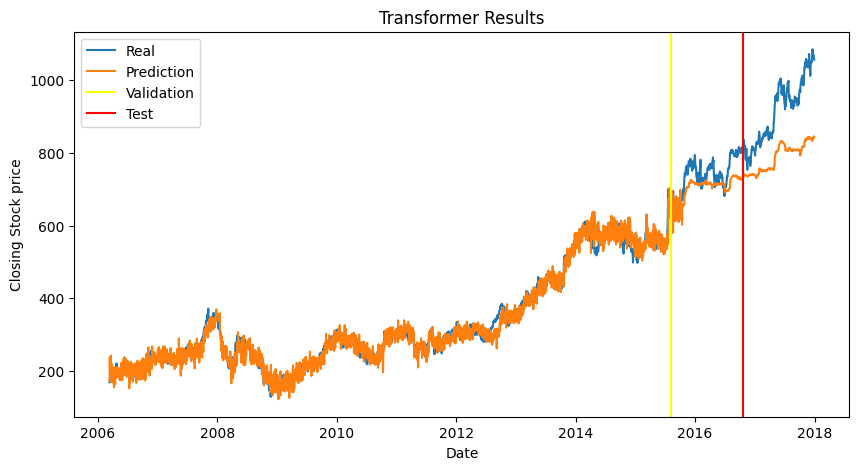

In [ ]:
plt.subplots(figsize=(10, 5))

plt.plot(df.index[50:], np.concatenate([y_train_arr, y_val_arr, y_test_arr]), label='Real')
plt.plot(df.index[50:], np.concatenate([y_pred_train, y_pred_val, y_pred_test]), label='Prediction')

plt.axvline(x = df.iloc[[train_samples]].index, color = 'yellow', label = 'Validation')
plt.axvline(x = df.iloc[[val_samples]].index, color = 'red', label = 'Test')

plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Stock price")
plt.title("Transformer Results")
plt.show()

In [ ]:
# Getting metrics
# MSE
train_rmse_transformer = np.sqrt( mean_squared_error( y_train_arr, y_pred_train ) )
val_rmse_transformer = np.sqrt( mean_squared_error( y_val_arr, y_pred_val ) )
test_rmse_transformer = np.sqrt( mean_squared_error( y_test_arr, y_pred_test ) )

# MAE
train_mae_transformer = mean_absolute_error(  y_train_arr, y_pred_train  )
val_mae_transformer = mean_absolute_error( y_val_arr, y_pred_val )
test_mae_transformer = mean_absolute_error( y_test_arr, y_pred_test )

# Results

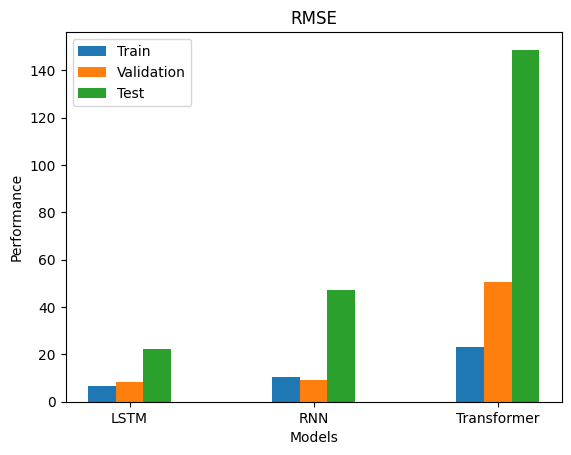

In [ ]:
# RMSE results
x_arr = np.arange(3)*2
plt.bar(x_arr-0.3, [train_rmse_LSTM, train_rmse_rnn, train_rmse_transformer], label='Train', width=0.3)
plt.bar(x_arr, [val_rmse_LSTM, val_rmse_rnn, val_rmse_transformer], label='Validation',width=0.3)
plt.bar(x_arr+0.3, [test_rmse_LSTM, test_rmse_rnn, test_rmse_transformer], label='Test', width=0.3)

plt.xticks(x_arr, ['LSTM', 'RNN', 'Transformer'])
plt.xlabel("Models")
plt.ylabel("Performance")
plt.title("RMSE")
plt.legend()
plt.show()

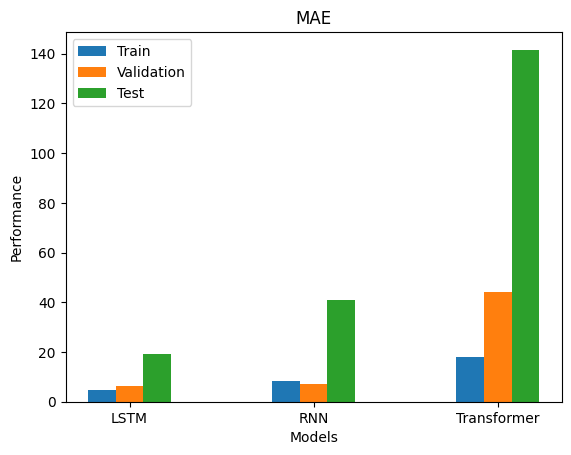

In [ ]:
# MAE results
x_arr = np.arange(3)*2
plt.bar(x_arr-0.3, [train_mae_LSTM, train_mae_rnn, train_mae_transformer], label='Train', width=0.3)
plt.bar(x_arr, [val_mae_LSTM, val_mae_rnn, val_mae_transformer], label='Validation', width=0.3)
plt.bar(x_arr+0.3, [test_mae_LSTM, test_mae_rnn, test_mae_transformer], label='Test', width=0.3)

plt.xticks(x_arr, ['LSTM', 'RNN', 'Transformer'])
plt.xlabel("Models")
plt.ylabel("Performance")
plt.title("MAE")
plt.legend()
plt.show()

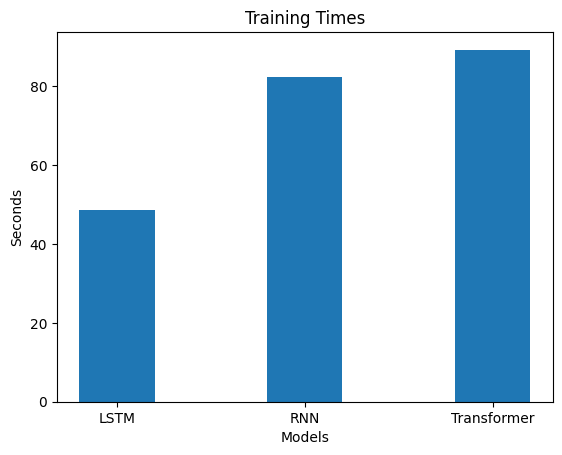

In [ ]:
# Training times
plt.bar(x_arr, [lstm_training_time, rnn_training_time, transformer_training_time])
plt.xlabel("Models")
plt.ylabel("Seconds")
plt.title("Training Times")

plt.xticks(x_arr, ['LSTM', 'RNN', 'Transformer'])

plt.show()